In [1]:
!pip install opencv-python

In [19]:
import cv2
import numpy as np 
import pandas as pd 
import os
import random
import shutil
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns

# image processing
from tensorflow.keras.preprocessing.image import ImageDataGenerator
#keras models
from tensorflow.keras import layers ,models,optimizers
from keras.layers import Dropout, Flatten, Dense, Conv2D, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.utils import plot_model
from keras.models import Sequential
#resnet50
from tensorflow.keras.applications import resnet50
from tensorflow.keras.applications.imagenet_utils import preprocess_input 
#stop criteria
from tensorflow.keras.callbacks import EarlyStopping
#cnn_visualisation
from keras.preprocessing import image
import random

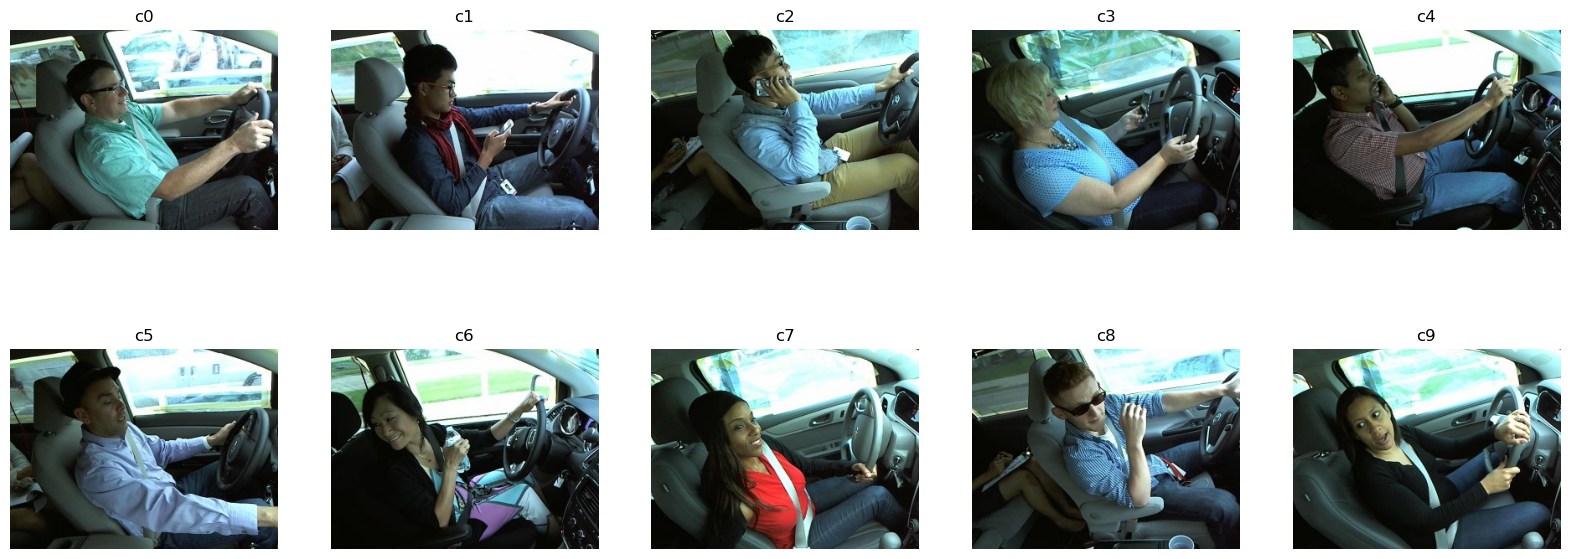

In [6]:
TRAIN_DIR = "datasets_resnet/imgs/train/"
labels = ['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9']

#randomly selecting one image per class

img_c0_path = TRAIN_DIR + "c0/" + random.choice(os.listdir(TRAIN_DIR + "c0/"))
img_c1_path = TRAIN_DIR + "c1/" + random.choice(os.listdir(TRAIN_DIR + "c1/"))
img_c2_path = TRAIN_DIR + "c2/" + random.choice(os.listdir(TRAIN_DIR + "c2/"))
img_c3_path = TRAIN_DIR + "c3/" + random.choice(os.listdir(TRAIN_DIR + "c3/"))
img_c4_path = TRAIN_DIR + "c4/" + random.choice(os.listdir(TRAIN_DIR + "c4/"))
img_c5_path = TRAIN_DIR + "c5/" + random.choice(os.listdir(TRAIN_DIR + "c5/"))
img_c6_path = TRAIN_DIR + "c6/" + random.choice(os.listdir(TRAIN_DIR + "c6/"))
img_c7_path = TRAIN_DIR + "c7/" + random.choice(os.listdir(TRAIN_DIR + "c7/"))
img_c8_path = TRAIN_DIR + "c8/" + random.choice(os.listdir(TRAIN_DIR + "c8/"))
img_c9_path = TRAIN_DIR + "c9/" + random.choice(os.listdir(TRAIN_DIR + "c9/"))

# reading the images
imgs = {}

imgs["c0"] = cv2.cvtColor(cv2.imread(img_c0_path), cv2.COLOR_BGR2RGB)
imgs["c1"] = cv2.cvtColor(cv2.imread(img_c1_path), cv2.COLOR_BGR2RGB)
imgs["c2"] = cv2.cvtColor(cv2.imread(img_c2_path), cv2.COLOR_BGR2RGB)
imgs["c3"] = cv2.cvtColor(cv2.imread(img_c3_path), cv2.COLOR_BGR2RGB)
imgs["c4"] = cv2.cvtColor(cv2.imread(img_c4_path), cv2.COLOR_BGR2RGB)
imgs["c5"] = cv2.cvtColor(cv2.imread(img_c5_path), cv2.COLOR_BGR2RGB)
imgs["c6"] = cv2.cvtColor(cv2.imread(img_c6_path), cv2.COLOR_BGR2RGB)
imgs["c7"] = cv2.cvtColor(cv2.imread(img_c7_path), cv2.COLOR_BGR2RGB)
imgs["c8"] = cv2.cvtColor(cv2.imread(img_c8_path), cv2.COLOR_BGR2RGB)
imgs["c9"] = cv2.cvtColor(cv2.imread(img_c9_path), cv2.COLOR_BGR2RGB)

# displaying the images
display_rows = 5
display_columns = 5
fig = plt.figure(figsize=(20, 20))

for label, index in zip(labels, range(10)):
    fig.add_subplot(display_rows, display_columns, index + 1)
    plt.imshow(imgs[label])
    plt.axis('off')
    plt.title(label)


original shape: (240, 320, 3)
Part 1 shape: (120, 160, 3)
Part 2 shape: (120, 160, 3)
Part 1 dtype: uint8
Part 2 dtype: uint8


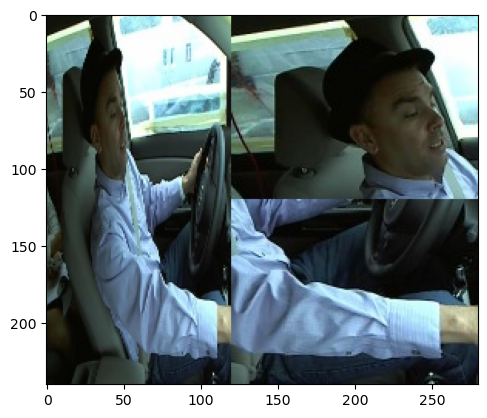

In [13]:
# adding focused details (head, arm) to the original image
img = cv2.cvtColor(cv2.imread(img_c5_path), cv2.COLOR_BGR2RGB)

print("original shape: " + str(img.shape))

# Split the image into two parts vertically
img_part1 = img[0:120, 0:160]
img_part2 = img[120:240, 160:320]

# Check the dimensions of the parts
print("Part 1 shape:", img_part1.shape)
print("Part 2 shape:", img_part2.shape)

# Check the data types of the parts
print("Part 1 dtype:", img_part1.dtype)
print("Part 2 dtype:", img_part2.dtype)

# Ensure the dimensions and data types are consistent before concatenating
detail_concat = cv2.vconcat([img_part1, img_part2])
original_resized = cv2.resize(img, (120, 240))

final_image = cv2.hconcat([original_resized, detail_concat])

plt.imshow(final_image)

In [16]:
class FocusedDataGenerator(tf.keras.preprocessing.image.ImageDataGenerator):
    def __init__(self, 
                **kwargs) -> None:

      # Declare a processing functions
      super().__init__(
          preprocessing_function=self.actions,
          **kwargs)
    
    def actions(self, image: np.ndarray) -> np.ndarray:
        # Apply focus operation
        image = self.focus(image)
        
        # Apply Keras preprocess_input function
        image = tf.keras.applications.resnet50.preprocess_input(image)

        return image

    def focus(self, img: np.ndarray) -> np.ndarray:
        height, width, _ = img.shape
        img_part1 = img[0:(height // 2), 0:(width // 2)]
        img_part2 = img[(height // 2):height, (width // 2):width]
        detail_concat = cv2.vconcat([img_part1, img_part2])
        original_resized = cv2.resize(img, ((width // 2), height))
        final_image = cv2.hconcat([original_resized, detail_concat])
        return final_image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


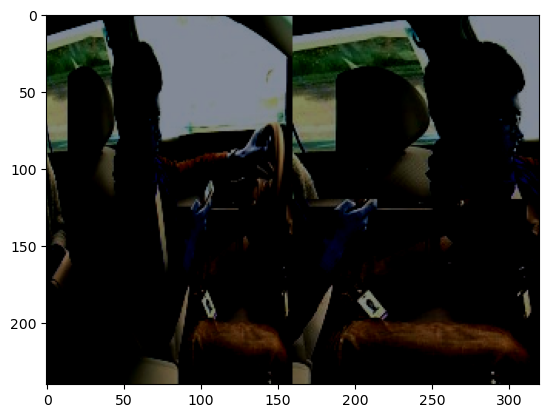

In [17]:
img = cv2.imread(img_c1_path)
img = np.expand_dims(img, axis = 0)
focused_img = FocusedDataGenerator(rescale=1./255)
focused_img.fit(img)
output = focused_img.flow(img)[0]
out = np.reshape(output, output.shape[1:4])
plt.imshow(cv2.cvtColor(out, cv2.COLOR_BGR2RGB))

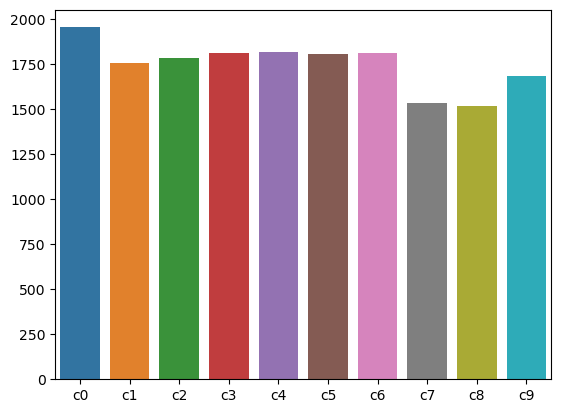

In [20]:
samples = {}
for label in labels:
    samples[label] = [len(os.listdir(TRAIN_DIR + label + "/"))]

samples_df = pd.DataFrame.from_dict(samples)
sns.barplot(data = samples_df)
plt.show()

In [21]:
batch_size = 20
base_learning_rate = 0.001
base_momentum=0.9
initial_epochs = 30
fine_tune_epochs = 40
fine_tune_at = 4
drop_out_rate = 0.0
initial_patience = 3
fine_tune_patience = 2

In [22]:
IMG_SIZE = (224, 224)
IMG_SHAPE = IMG_SIZE + (3,)
BASE_MODEL_LAYER = 1

preprocess_input = tf.keras.applications.resnet50.preprocess_input

data_augmentation = FocusedDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    #preprocessing_function=preprocess_input, # I have to make it such that some of the augmented images are the focused versions. Not everyone. Now it would be probabilistically everyone as I am preprocessing it like this with probability = 0.5
    validation_split=0.2
)

training_dataset = data_augmentation.flow_from_directory(TRAIN_DIR,
                                                        subset="training",
                                                        seed=123,
                                                        target_size=IMG_SIZE,
                                                        batch_size=batch_size,
                                                        class_mode='sparse',)
validation_dataset = data_augmentation.flow_from_directory(TRAIN_DIR,
                                                        subset="validation",
                                                        seed=123,
                                                        target_size=IMG_SIZE,
                                                        batch_size=batch_size,
                                                        class_mode='sparse')

Found 13975 images belonging to 10 classes.
Found 3487 images belonging to 10 classes.


In [24]:
base_model = tf.keras.applications.ResNet50(input_shape=IMG_SHAPE,
                                                   include_top=False,
                                                   weights='imagenet')
base_model.trainable = False
inputs = tf.keras.Input(shape=IMG_SHAPE)

x = base_model(inputs, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(drop_out_rate)(x)
outputs = tf.keras.layers.Dense(10, activation='softmax')(x)
model = tf.keras.Model(inputs, outputs)

loss_function = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

initial_optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate,
                                            momentum=base_momentum)

model.compile(optimizer=initial_optimizer,
              loss=loss_function,
              metrics=['accuracy'])

es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=initial_patience, restore_best_weights=True)

model.fit(training_dataset, validation_data=validation_dataset, epochs=initial_epochs, callbacks=[es])

Epoch 1/30
699/699 ━━━━━━━━━━━━━━━━━━━━ 1479s 2s/step - accuracy: 0.3360 - loss: 3.3189 - val_accuracy: 0.4743 - val_loss: 2.8982
Epoch 2/30
699/699 ━━━━━━━━━━━━━━━━━━━━ 1340s 2s/step - accuracy: 0.5511 - loss: 2.2384 - val_accuracy: 0.5933 - val_loss: 1.9837
Epoch 3/30
699/699 ━━━━━━━━━━━━━━━━━━━━ 1329s 2s/step - accuracy: 0.6190 - loss: 1.9950 - val_accuracy: 0.6295 - val_loss: 2.2736
Epoch 4/30
699/699 ━━━━━━━━━━━━━━━━━━━━ 1328s 2s/step - accuracy: 0.6263 - loss: 2.2111 - val_accuracy: 0.6920 - val_loss: 1.6555
Epoch 5/30
699/699 ━━━━━━━━━━━━━━━━━━━━ 1374s 2s/step - accuracy: 0.6620 - loss: 2.0459 - val_accuracy: 0.6894 - val_loss: 1.7612
Epoch 6/30
699/699 ━━━━━━━━━━━━━━━━━━━━ 1328s 2s/step - accuracy: 0.6881 - loss: 1.9027 - val_accuracy: 0.6645 - val_loss: 2.2092
Epoch 7/30
699/699 ━━━━━━━━━━━━━━━━━━━━ 1329s 2s/step - accuracy: 0.6944 - loss: 1.9500 - val_accuracy: 0.7164 - val_loss: 1.6454
Epoch 8/30
699/699 ━━━━━━━━━━━━━━━━━━━━ 1327s 2s/step - accuracy: 0.7021 - loss: 1.9074 - 

In [ ]:
base_model = model.layers[BASE_MODEL_LAYER]
base_model.trainable = True

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

fine_tuning_optimizer = tf.keras.optimizers.Adam(learning_rate=0.001 * base_learning_rate)
metrics=['accuracy']

model.compile(loss=loss_function,
              optimizer = fine_tuning_optimizer,
              metrics=metrics)

es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=fine_tune_patience, restore_best_weights=True)

history_fine = model.fit(training_dataset,
                         epochs=fine_tune_epochs,
                         validation_data=validation_dataset,
                         callbacks=[es])

model.save('fine_tuned_model.keras')

Epoch 1/40
699/699 ━━━━━━━━━━━━━━━━━━━━ 4873s 7s/step - accuracy: 0.4253 - loss: 5.7719 - val_accuracy: 0.5546 - val_loss: 3.5603
Epoch 2/40
699/699 ━━━━━━━━━━━━━━━━━━━━ 4947s 7s/step - accuracy: 0.5689 - loss: 3.2141 - val_accuracy: 0.6349 - val_loss: 2.4529
Epoch 3/40
699/699 ━━━━━━━━━━━━━━━━━━━━ 5011s 7s/step - accuracy: 0.6474 - loss: 2.2419 - val_accuracy: 0.6911 - val_loss: 1.9453
Epoch 4/40
699/699 ━━━━━━━━━━━━━━━━━━━━ 5046s 7s/step - accuracy: 0.7041 - loss: 1.7071 - val_accuracy: 0.7362 - val_loss: 1.5267
Epoch 5/40
699/699 ━━━━━━━━━━━━━━━━━━━━ 4716s 7s/step - accuracy: 0.7330 - loss: 1.5124 - val_accuracy: 0.7795 - val_loss: 1.2982
Epoch 6/40
699/699 ━━━━━━━━━━━━━━━━━━━━ 5230s 7s/step - accuracy: 0.7550 - loss: 1.3138 - val_accuracy: 0.7895 - val_loss: 1.1787
Epoch 7/40
699/699 ━━━━━━━━━━━━━━━━━━━━ 4847s 7s/step - accuracy: 0.7820 - loss: 1.1604 - val_accuracy: 0.8102 - val_loss: 1.0223
Epoch 8/40
699/699 ━━━━━━━━━━━━━━━━━━━━ 4597s 7s/step - accuracy: 0.8005 - loss: 1.0264 - 